# Modelling of air-quality in Belgium for forecasting purposes using Deep Neural Networks

#### Konstantinos Theodorakos  
*Katholieke Universiteit Leuven*  
*Student of the Master Artificial Intelligence: Engineering and Computer Science*  
*Faculty of Engineering Science*  
*Departments of Computer Science & Electrical Engineering, ESAT-STADIUS*  
*Kasteelpark Arenberg 10*  
*Leuven (Heverlee), Belgium*  
*Email: Konstantinos.Theodorakos@student.kuleuven.be*

# BACKGROUND

## Ozone

Ozone (see: https://en.wikipedia.org/wiki/Ozone ), is an inorganic molecule, a less stable allotrope of oxygen. It has industrial and consumer applications as an oxidant, but it causes damage to mucous and respiratory tissues of humans and animals.

![Alt Text](pics/1200px-Atmospheric_ozone.svg.png)

*Figure: Ozone distribution on the Earth's atmosphere (source: https://en.wikipedia.org/wiki/File:Atmospheric_ozone.svg ).*

# 1. METHODS
## Data handling & time-series split

Sensor data points that were flagged as invalid were omitted entirely. For the 1-station ozone prediction experiments, linear interpolation is filling the missing values. For all the other 4+ station experiments, missing data points are covered by: (1) data from the geographically closest stations and (2) linear interpolation (in case there are still missing values).

For the model selection, a unique form of k-fold cross-validation was used: **time-series split** [3] see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html ). In each split, shuffling is omitted, in order to retain the sequence of the full time-series. In addition, the model is trained with data of increasing total time-step count. The mean validation Mean Squared Error (MSE) determines whether a model is optimal and generalizes well. The "test" data is held-out from the start, never used in model selection. For all the experiments, time-series split had had 10-folds.
![title](pics/timeSeriesValidateSplit.png)


## Neuroevolution with "Island Transpeciation"

Neuroevolution [21] is an algorithmic method that utilizes *Evolutionary Algorithms* *(EA)* [18] to generate Artificial Neural Network (ANN) [22] parameters, topologies [5, 6, 10, 11, 12] and rules (see: https://en.wikipedia.org/wiki/Neuroevolution ). In order to find an optimal deep learning model for the time-series forecasting [8, 9] task, architecture search is performed in conjunction with hyper-parameter tuning [23, 34]. Speciation is the evolutionary process by which populations evolve to become distinct species (see: https://en.wikipedia.org/wiki/Speciation ). With *island speciation*, neuroevolution can be parallelized: Each island [24, 33] can be a distinct thread, process or even a different computing node. Even though the evolution progresses distinctly in each island, populations of meta-learning agents migrate periodically between islands.

Every island can have the same global optimization technique (with similar or different settings versus the other islands), a **species**. A global optimizer like Differential Evolution (DE) [17] (see: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html ), maintains a number of different agents internally, that are used in a parameter search. An agent has a different internal representation (*genotype*) depending on the meta-heuristic algorithm. The actual bounded parameter set, the *phenotype*, is a candidate Deep Neural Network (DNN) [6] model architecture that we try to optimize. Within the DE implementation, there exist 2-way operations that can perform genotype-to-phenotype representation conversions and vice-versa.

Three types of global optimization EA islands were used:
- **Random (Rand)** [19] island. Creates a random model, by sampling the bounded hyper-parameter values from a uniform pseudo-random number generator. In this case genotype = phenotype and the island population is 1.

- **Differential Evolution** island. Genotype: energy (real values in [0,1]). Phenotype: the genotype values, scaled from [0, 1] into the bounds of each parameter.
![Alt Text](pics/Ackley.gif)
*Figure: Example of Differential Evolution optimizing the 2D Ackley function using a population of size 20 (source: https://en.wikipedia.org/wiki/Differential_evolution#/media/File:Ackley.gif ).*


- **Particle Swarm Optimization (PSO)** [16] island (see: https://pythonhosted.org/pyswarm/ ). Genotype: position (multi-dimensional representation of the parameters as real values) and velocity (rate of change of the positions).
![Alt Text](pics/ParticleSwarmArrowsAnimation.gif)
*Figure: A particle swarm searching for the global minimum of a function (source: https://en.wikipedia.org/wiki/Particle_swarm_optimization#/media/File:ParticleSwarmArrowsAnimation.gif ).*

In some cases, it is possible to convert an agent from one global optimization method to another. For example, to convert a DE to a PSO agent: the agent of the DE "species" is converted from the DE genotype to the common phenotype (by unscaling real values) and then is converted to the PSO genotype (real values = position & velocity). We define this conversion process as **island transpeciation** (see: http://www.websters1913.com/words/Transpeciate ). Loosely termed, transpeciation acts as a (lossy in some cases) *transformation function* between the agent genotypes of different global optimization functions. Transpeciation in conjunction with the island model, allow combination (via *migration*) and diversification (via unique evolution per island) of different model architecture search methods.

Worth noting is that in order to keep the populations stable on all islands, the migrating agents replace a random agent at the receiving island. In practice, it was a matter of replacing an agent entry on the internal data structures of the EA algorithms. For the local experiments, the island population was fixed to 5 agents.

In the future, there will be attempts to integrate additional meta-learning islands such as:
- Genetic Algorithm (GA) [13, 14, 15].
- (Multi-agent) Reinforcement Learning (RL) [4].
- Basin Hopping (BH) [20].
- Estimation of distribution algorithms (EDA) [26], or probabilistic model-building genetic algorithms (PMBGAs) [25].
- Tree-structured Parzen Estimator (TPE) [34].

![title](pics/agentIslandTranspeciation.png)

## Architecture search genes

The genes are expressed as bounded real or integer values. They can represent:
- Cells/layers of a sequential DNN.
- Various model hyper-parameters/rates.
- Training optimizers.

### Cell Sequence search

The candidate models contain 4 base layers:
- 3x Long-Short Term Memory (**LSTM**) [27].
- 1x **Fully Connected** cell at the end.

The **auxiliary/utility cells** are placed between the base layers. Auxiliary cells placements are determined purely by the evolutionary search process:

- Batch Normalization [36].
- Gaussian Noise [37].

![title](pics/cells.png)

### Hyper-Parameter search

The following **bounded parameters** (ranges expressed in the parentheses) are searched:
- Standard Deviation of the Gaussian noise.
- Dropout/Recurrent-dropout [35] rate: Fraction of neurons to randomly ignore while training; reduces overfitting.
- Cell/layer size.
- Max training epochs.
- Batch size per epoch.




![title](pics/hyperParameters.png)

### Optimizer search

**Optimizers** are the algorithms that guide the weight training process of an ANN. The following optimizer options are possible (https://keras.io/optimizers/):

- Adagrad (Adaptive Subgradient) [38].
- Adadelta [39].
- Adam, adamax [40].
- Adam (amsgrad version) [41].
- Nadam (adam with Nesterov momentum) [42].

![title](pics/optimizers.png)

It is a subset of the total optimizers available, the only valid options for Recurrent Neural Networks (RNN).

### Overfitting avoidance

**Early Stopping** and **Learning-Rate reduction on plateau** (see: https://keras.io/callbacks/ ) use the *loss* and *validation_loss* values of Mean Squared Error (MSE) during training, to approach a finely-trained model and to avoid overfitting.

### Parallelism
An asynchronous version of the **Master-Slave pattern** (see: http://charm.cs.uiuc.edu/research/masterSlave ) allowed for CPU and GPU parallelism of different island species. Agent migration is carried out by slaves (islands) sending candidates to the master (main CPU process). The master decides when and to which island to migrate an agent. **Message Passing Interface (MPI)** (see: https://www.mpi-forum.org/docs/ ) handles the communication between the islands and the master (see: https://mpi4py.readthedocs.io/en/stable/tutorial.html#point-to-point-communication ).

The parallel implementation was tested on a local workstation (6 physical CPU cores, 2x Cuda capable GPUs), as well as on the Amazon Elastic Compute Cloud (EC2), on a p3.8xlarge Amazon Machine Image (AMI) (see: https://aws.amazon.com/ec2/instance-types/p3/ ) containing 4x Tesla V100 GPUs. *Note: unfortunately, for now, the models/weights trained on the cloud are incompatible with the local tensorflow installation. After the completion of the "Python for HPC" seminar, the GPU cluster of the VSC super-computer will be utilized (see: https://www.vscentrum.be/ )*.

# 2. MODELS & RESULTS
## Naive method, using the previous step (Naive-1)

The Naive-1 method is the simplest forecasting model, which can serve as a benchmark against the more sophisticated methods.

Background-rural both for Ozone (O3 - Max daily 8-hour mean max8h ozone concentrations) is being read from disk as a CSV file (Older database: https://www.eea.europa.eu/data-and-maps/data/airbase-the-european-air-quality-database-8) for the stations in Belgium: BETN073.

In [17]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot
# Make plots inline
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

station = "BETN073"
modelLabel = "rand"

dataManipulation = {
    "detrend": False,
    "scale": None,
#     "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

row2000_01_01 = 3653 - 1
row2010_12_31 = 7670
r = r[row2000_01_01:row2010_12_31,:]

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)
print("y_data shape:", y_data.shape)
y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

Loading data...
Using scale: None
r shape: (8035, 59)

Start Array r:
 27.25
Variables: 52
TimeSteps: 4018
x_data shape: (4018, 52)
y_data shape: (4018, 1)


Store data to csv for direct comparisons:

In [18]:
print(r.shape)
print(r[0, 0], r[1, 0], r[-2, 0], r[-1, 0])

(4018, 53)
27.25 38.875 38.5 34.25


In [19]:
import pandas as pd
df1 = pd.DataFrame(r)
df1.to_csv('data_51vars_comparisons.csv')

### Naive-1 prediction & metrics

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return 100.0 * np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %
def index_of_agreement(validation, prediction):
    return 1 - (np.sum((validation - prediction) ** 2)) / (np.sum((np.abs(prediction - 
      np.mean(validation)) + np.abs(validation - np.mean(validation))) ** 2))

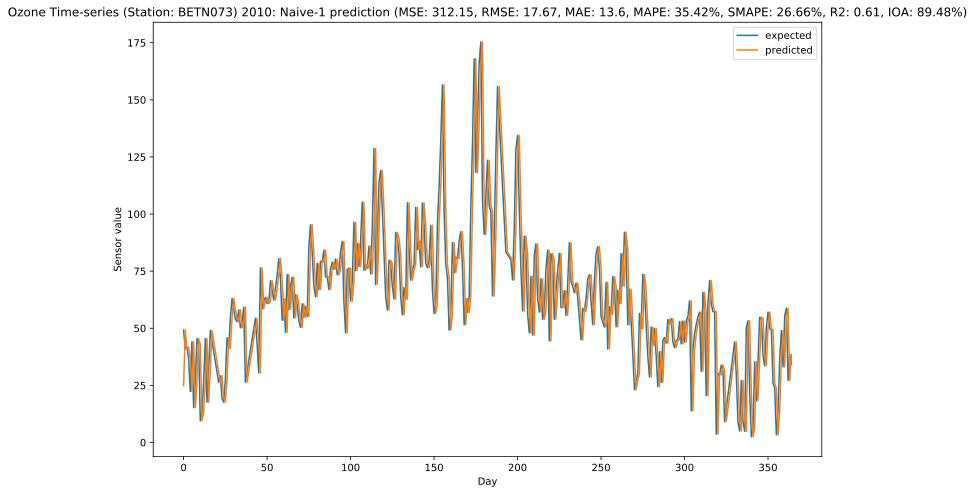

In [21]:
year = 2010
lag = 1
data = r[-365:,0]
ts_lag1 = r[-365:,52]

MSE = mean_squared_error(data, ts_lag1)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(data, ts_lag1)
naive_MAE = MAE
MAPE = mean_absolute_percentage_error(data, ts_lag1)
SMAPE = smape(data, ts_lag1)
R2_score = r2_score(data, ts_lag1)
IOA = index_of_agreement(data, ts_lag1)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: Naive-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(data)
pyplot.plot(ts_lag1)
ax.legend(['expected', 'predicted'])

Metric Abbreviations:
- MSE: Mean Squared Error
- MAE: Mean Absolute Error
- MAPE: Mean Absolute Percentage Error [32]
- SMAPE: Symmetric Mean Absolute Percentage Error [29, 30]
- IoA: Index of Agreement [31]

## Naive LSTM Multiple-Input Single-Output (MISO) Nonlinear AutoRegressive eXogenous model with lag of 1 day (NARX-1)

The Naive LSTM model, is one of the simplest recurrent models possible: uses a single LSTM layer and 1 fully connected layer at the end. The typical Recurrent Neural Network (RNN) and Gated Recurrent Unit (GRU) layer options on this simple architecture were dropped, due to inferior performance (see: https://keras.io/layers/recurrent/ ), with Mean Absolute Percentage Error (MAPE) ~ 65%, much worse than the Naive-1 baseline.

Loading of the standardized data (1 sensor prediction + 51 weather variables [28]):

In [22]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
#     "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

row2000_01_01 = 3653 - 1
row2010_12_31 = 7670
r = r[row2000_01_01:row2010_12_31,:]
print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)
print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

Loading data...
Using scale: standardize
r shape: (8035, 59)

Start Array r:
 -1.1751806026215357
Variables: 52
TimeSteps: 4018
x_data shape: (4018, 52)
y_data shape: (4018, 1)


In [28]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

import numpy as np
from keras.models import model_from_json
import pandas as pd

# json_file = open('runs/naiveLstm/foundModels/bestModelArchitecture.json', 'r')
json_file = open('runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/local/foundModels/bestModelArchitecture.json', 'r')
#json_file = open('runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/TX2/foundModels/bestModelArchitecture.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/naiveLstm/foundModels/bestModelWeights.h5")
loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/local/foundModels/bestModelWeights.h5")
#loaded_model.load_weights("runs/18CellularAutomata3DGrid3x3x3_5AgentsO3_2000-2010_1_station_lerp/TX2/foundModels/bestModelWeights.h5")

In [24]:
sensor_mean = pd.read_pickle("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_mean.pkl")
sensor_std = pd.read_pickle("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

In [25]:
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [26]:
# holdout_prediction = loaded_model.predict(x_data_holdout)
# figure_size = (8, 6)

# prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
# y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

# MSE = mean_squared_error(y_validation, prediction)
# RMSE = np.sqrt(MSE)
# MAE = mean_absolute_error(y_validation, prediction)
# MAPE = mean_absolute_percentage_error(y_validation, prediction)
# SMAPE = smape(y_validation, prediction)
# R2_score = r2_score(y_validation, prediction)
# IOA = index_of_agreement(y_validation, prediction)

# fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# # ax.set_ylabel('Sensor value')
# ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
# ax.set_xlabel('Day')
# # ax.set_title('Ozone Time-series (Station: {}) {}: Naive LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
# ax.set_title('Ozone {} {}: Island DNN (MSE: {}, MAPE: {}%, IOA: {}%)'.format(station, year, np.round(MSE,2), np.round(MAPE,2), np.round(IOA * 100,2)))
# pyplot.plot(y_validation)
# pyplot.plot(prediction)
# ax.legend(['expected', 'predicted'])
# ax.grid(True)
# # fig.savefig('naiveLstmBETN073.svg', bbox_inches='tight')
# fig.savefig('islandDNN_BETN073_reruns.svg')

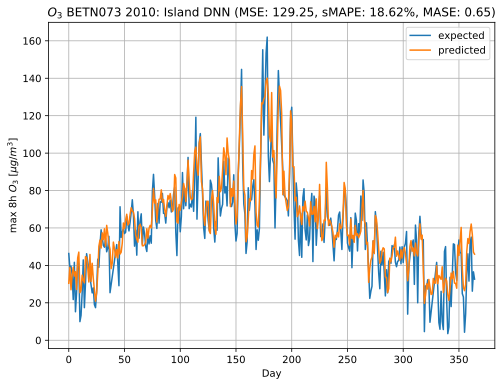

In [98]:
holdout_prediction = loaded_model.predict(x_data_holdout)
figure_size = (8, 6)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

MASE = MAE / naive_MAE

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
#ax.set_title('$O_3$ {} {}: Island DNN (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, MASE: {}, IOA: {}%)'.format(station, year, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(MASE,2), np.round(IOA * 100,2)))
ax.set_title('$O_3$ {} {}: Island DNN (MSE: {}, sMAPE: {}%, MASE: {})'.format(station, year, np.round(MSE,2), np.round(SMAPE,2),np.round(MASE,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])
ax.grid(True)
# fig.savefig('naiveLstmBETN073.svg', bbox_inches='tight')
fig.savefig('islandDNN_BETN073_reruns.svg')
fig.savefig('islandDNN_BETN073_reruns.png')

Tree ensemble:

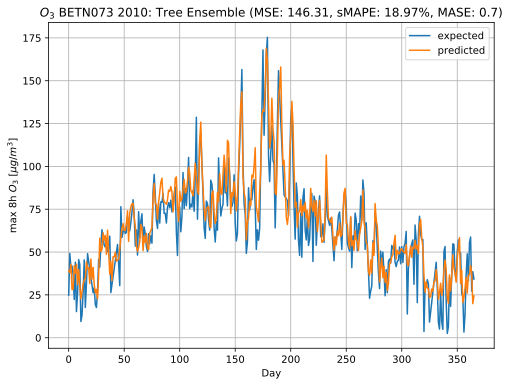

In [99]:
from numpy import genfromtxt
prediction = genfromtxt('ensemble_y_test_prediction.csv', delimiter=',')
y_validation = genfromtxt('ensemble_y_test_matrix.csv', delimiter=',')

#holdout_prediction = loaded_model.predict(x_data_holdout)
figure_size = (8, 6)

#prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
#y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

MASE = MAE / naive_MAE

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
#ax.set_title('$O_3$ {} {}: Tree Ensemble (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, MASE: {}, IOA: {}%)'.format(station, year, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(MASE,2), np.round(IOA * 100,2)))
ax.set_title('$O_3$ {} {}: Tree Ensemble (MSE: {}, sMAPE: {}%, MASE: {})'.format(station, year, np.round(MSE,2), np.round(SMAPE,2),np.round(MASE,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])
ax.grid(True)
# fig.savefig('naiveLstmBETN073.svg', bbox_inches='tight')
fig.savefig('tree_ensemble_BETN073_reruns.svg')
fig.savefig('tree_ensemble_BETN073_reruns.png')

LSSVM:

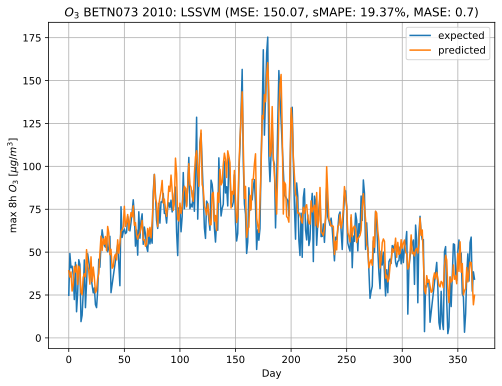

In [95]:
from numpy import genfromtxt
prediction = genfromtxt('LSSVM_y_test_prediction.csv', delimiter=',')
y_validation = genfromtxt('LSSVM_y_test_matrix.csv', delimiter=',')

#holdout_prediction = loaded_model.predict(x_data_holdout)
figure_size = (8, 6)

#prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
#y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

MASE = MAE / naive_MAE

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=figure_size, sharex=True, sharey=True)
# ax.set_ylabel('Sensor value')
ax.set_ylabel('max 8h 'r'$O_3$ $[\mu g/m^3$]')
ax.set_xlabel('Day')
#ax.set_title('$O_3$ {} {}: LSSVM (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, MASE: {}, IOA: {}%)'.format(station, year, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(MASE,2), np.round(IOA * 100,2)))
ax.set_title('$O_3$ {} {}: LSSVM (MSE: {}, sMAPE: {}%, MASE: {})'.format(station, year, np.round(MSE,2), np.round(SMAPE,2),np.round(MASE,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])
ax.grid(True)
# fig.savefig('naiveLstmBETN073.svg', bbox_inches='tight')
fig.savefig('LSSVM_BETN073_reruns.svg')
fig.savefig('LSSVM_BETN073_reruns.png')

NameError: name 'pyplot' is not defined

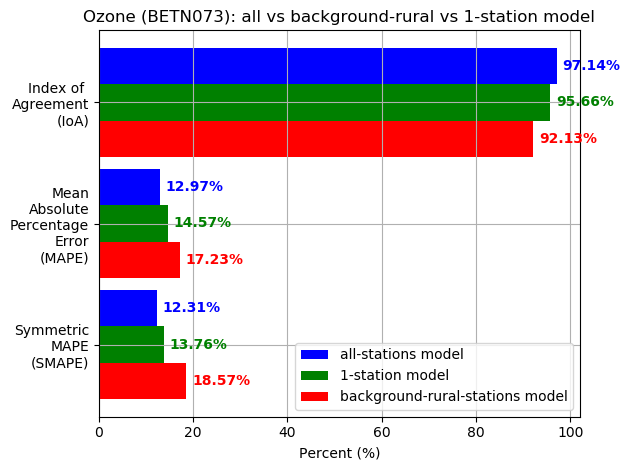

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
labels = ['Symmetric\nMAPE\n(SMAPE)', 'Mean\nAbsolute\nPercentage\nError\n(MAPE)', 'Index of \nAgreement\n(IoA)']
# mape = [14.57, 12.97]
# ioa = [95.65, 97.14]
# smape = [13.76, 12.31]

model1 = [13.76, 14.57, 95.66]
model18 = [18.57, 17.23, 92.13]
model46 = [12.31, 12.97, 97.14]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x + width, model46, width, label='all-stations model', color='b')
rects2 = ax.barh(x, model1, width, label='1-station model', color='g')
rects3 = ax.barh(x - width, model18, width, label='background-rural-stations model', color='r')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percent (%)')
ax.set_title('Ozone (BETN073): all vs background-rural vs 1-station model')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(True)

def autolabel(rects, color):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}%'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(25, -5),  # 3 points vertical offset
                    fontweight='bold',
                    color=color,
                    textcoords="offset points",
                    ha='center', va='bottom')        

autolabel(rects1, 'b')  
autolabel(rects2, 'g')     
autolabel(rects3, 'r') 

fig.tight_layout()

# plt.show()
# pyplot.savefig("betn073_allVsbackground-ruralVs1-station.svg")

### References:
[1] J. Orellana Alvear. Application of LS-SVMs to ozone forecasting in Belgium, 2015.  
[2] Denis Dumoulin. Fixed-Size Multi-Output LSSVM for Nonlinear System Identification, 2017.  
[3] Christoph Bergmeir, Rob J Hyndman, Bonsoo Koo (2018) A note on the validity of cross-validation for evaluating autoregressive time series prediction. Computational Statistics and Data Analysis, 120, 70-83.  
[4] Neural Architecture Search with Reinforcement Learning, Barret Zoph, Quoc V. Le. International Conference on Learning Representations, 2017.  
[5] Using Evolutionary AutoML to Discover Neural Network Architectures - https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html  
[6] Ian Goodfellow, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. The MIT Press.  
[7] Esteban Real, Sherry Moore, Andrew Selle, Saurabh Saxena, Yutaka Leon Suematsu, Jie Tan, Quoc Le: "Large-Scale Evolution of Image Classifiers", 2017  
[8] Lingxue Zhu: "Deep and Confident Prediction for Time Series at Uber", 2017, 2017 IEEE International Conference on Data Mining Workshops. DOI: 10.1109/ICDMW.2017.19  
[9] Makridakis S, Spiliotis E, Assimakopoulos V (2018) Statistical and Machine Learning forecasting methods: Concerns and ways forward. PLOS ONE 13(3): e0194889. https://doi.org/10.1371/journal.pone.0194889  
[10] Esteban Real, Alok Aggarwal, Yanping Huang: "Regularized Evolution for Image Classifier Architecture Search", 2018  
[11] Xin Yao, "Evolving artificial neural networks," in Proceedings of the IEEE, vol. 87, no. 9, pp. 1423-1447, Sept. 1999.
doi: 10.1109/5.784219  
[12] Risto Miikkulainen, Jason Liang, Elliot Meyerson, Aditya Rawal, Dan Fink, Olivier Francon, Bala Raju, Hormoz Shahrzad, Arshak Navruzyan, Nigel Duffy: "Evolving Deep Neural Networks", 2017  
[13] Kenneth O. Stanley and Risto Miikkulainen: "Evolving Neural Networks Through Augmenting Topologies",  Evolutionary Computation  
[14] Variable Length Genomes for Evolutionary Algorithms –C. -y. Lee — 2000 — In Proceedings of the Genetic and Evolutionary Computation Conference, 806. Las Vegas  
[15] Tim Kovacs: Genetics-Based Machine Learning. Handbook of Natural Computing 2012: 937-986  
[16] Kennedy, J.; Eberhart, R. (1995). "Particle Swarm Optimization". Proceedings of IEEE International Conference on Neural Networks. IV. pp. 1942–1948. doi:10.1109/ICNN.1995.488968.  
[17] Storn, R., & Price, K. (1997). Differential Evolution – A Simple and Efficient Heuristic for global Optimization over Continuous Spaces. Journal of Global Optimization, 11(4), 341–359. https://doi.org/10.1023/A:1008202821328  
[18] P. A. Vikhar, "Evolutionary algorithms: A critical review and its future prospects," 2016 International Conference on Global Trends in Signal Processing, Information Computing and Communication (ICGTSPICC), Jalgaon, 2016, pp. 261-265.
doi: 10.1109/ICGTSPICC.2016.7955308  
[19] James Bergstra and Yoshua Bengio. 2012. Random search for hyper-parameter optimization. J. Mach. Learn. Res. 13 (February 2012), 281-305.  
[20] Wales, David J.; Doye, Jonathan P. K. (1997-07-10). "Global Optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms". The Journal of Physical Chemistry A. 101 (28): 5111–5116. doi:10.1021/jp970984n.  
[21] Stanley, Kenneth O. (2017-07-13). "Neuroevolution: A different kind of deep learning". O'Reilly Media. Retrieved 2017-09-04.  
[22] McCulloch, Warren; Walter Pitts (1943). "A Logical Calculus of Ideas Immanent in Nervous Activity". Bulletin of Mathematical Biophysics. 5 (4): 115–133. doi:10.1007/BF02478259.  
[23] Claesen, Marc, and Bart De Moor. "Hyperparameter Search in Machine Learning." arXiv preprint arXiv:1502.02127 (2015)  
[24] W.N. Martin, J. Lienig, and J.P. Cohoon. Island (migration) models: evolutionary algorithms based on punctuated equilibria. Evolutionary Computation 2: Advanced Algorithms and Operators. Institute of Physics Publishing, Bristol, 2000, chapter 15, pages 101–124.  
[25] Pelikan M. () Probabilistic Model-Building Genetic Algorithms. In: Hierarchical Bayesian Optimization Algorithm. Studies in Fuzziness and Soft Computing, vol 170. Springer, Berlin, Heidelberg  
[26] Pedro Larrañaga; Jose A. Lozano (2002). Estimation of Distribution Algorithms a New Tool for Evolutionary Computation. Boston, MA: Springer US. ISBN 978-1-4615-1539-5.  
[27] Sepp Hochreiter; Jürgen Schmidhuber (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780. doi:10.1162/neco.1997.9.8.1735  
[28] Dee DP, Uppala SM, Simmons AJ, Berrisford P, Poli P, Kobayashi S, Andrae U, Balmaseda MA,Balsamo G, Bauer P, Bechtold P, Beljaars ACM, van deBerg L, Bidlot J, Bormann N, Delsol C, Dragani R,Fuentes  M,  Geer  AJ,  Haimberger  L,  Healy  SB,  Hersbach  H,  H ́olm  EV,  Isaksen  L,  K ̊allberg  P,  K ̈ohler  M,Matricardi M, McNally AP, Monge-Sanz BM, Morcrette J-J, Park B-K, Peubey C, de Rosnay P, Tavolato C,Th ́epaut  J-N,  Vitart  F.  2011.  The  ERA-Interim  reanalysis:  configuration  and  performance  of  the  dataassimilation system.Q. J. R. Meteorol. Soc.137: 553 – 597. DOI:10.1002/qj.828  
[29] Armstrong, J. S. (1978). Long-range Forecasting: From Crystal Ball to Computer, Wiley.  
[30] Tofallis, C (2015) "A Better Measure of Relative Prediction Accuracy for Model Selection and Model Estimation", Journal of the Operational Research Society, 66(8),1352-1362.  
[31] Willmott, C. J., S. G. Ackleson, R. E. Davis, J. J. Feddema, K. M. Klink, D. R. Legates, J. O'Donnell, and C. M. Rowe (1985), Statistics for the evaluation and comparison of models, J. Geophys. Res., 90(C5), 8995–9005, doi:10.1029/JC090iC05p08995.  
[32] Makridakis, Spyros, (1993), Accuracy measures: theoretical and practical concerns, International Journal of Forecasting, 9, issue 4, p. 527-529.  
[33] Tomassini, M. (2005). Spatially Structured Evolutionary Algorithms. New York. Springer. https://doi.org/10.1007/3-540-29938-6  
[34] Bergstra, J., Bardenet, R., Bengio, Y., & Kégl, B. (2011). Algorithms for Hyper-Parameter Optimization. In Proceedings of Neural Information Processing Systems (NIPS), 2011. https://doi.org/2012arXiv1206.2944S  
[35] Srivastava, N., Hinton, G., Krizhevsky, A., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research (Vol. 15). Retrieved from http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf  
[36] Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Retrieved from http://arxiv.org/abs/1502.03167  
[37] Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017). Self-Normalizing Neural Networks. Retrieved from http://arxiv.org/abs/1706.02515  
[38] Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).  
[39] Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method.  
[40] Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization.  
[41] Reddi, S. J., Kale, S., & Kumar, S. (2018). On the Convergence of Adam and Beyond. In Proceedings of the International Conference on Learning Representations (ICLR).  
[42] Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013). On the importance of initialization and momentum in deep learning.  